In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.animation
import yaml
import cv2
from scipy.spatial.transform import Rotation
from matplotlib.patches import Rectangle
from tqdm import tqdm
import argparse

sys.path.append('/home/schiavazza/code/hpe/hpe-core/datasets/')
sys.path.append('/local_code/hpe-core/datasets/')

from vicon_processing.src.projection import ProjectionHelper
from vicon_processing.src.data_helpers import DvsLabeler, DvsHelper, C3dHelper
from vicon_processing.src import vis_utils, utils

In [2]:
# import the DVS data
dvs_file_path = "/home/schiavazza/data/hpe/vicon_dataset/drum_s1/atis-d/"
dvs_helper = DvsHelper(dvs_file_path)

# reading events
print('Loading events... (may take a while)')
dvs_helper.read_events()
print('Done loading events, generating video...')

no manual zero time found, using zero instead
Loading events... (may take a while)
importIitYarp trying path: /home/schiavazza/data/hpe/vicon_dataset/drum_s1/atis-d/


100%|██████████| 15745/15745 [00:47<00:00, 329.53it/s]


Examining info.log: /home/schiavazza/data/hpe/vicon_dataset/drum_s1/atis-d/info.log
Done loading events, generating video...


In [7]:
# load c3d vicon data
c3d_file_path = "/home/schiavazza/data/hpe/vicon_dataset/drum_s1/drum_s1.c3d"
c3d_helper = C3dHelper(c3d_file_path, delay=0.0, camera_markers=True)

labels = [l.strip() for l in c3d_helper.reader.point_labels]

print(f"Loaded labels: {labels}")

Loaded labels: ['camera:cam_right', 'camera:cam_back', 'camera:cam_left', 'P11:LFHD', 'P11:RFHD', 'P11:LBHD', 'P11:RBHD', 'P11:C7', 'P11:T10', 'P11:CLAV', 'P11:STRN', 'P11:RBAK', 'P11:LSHO', 'P11:LUPA', 'P11:LELB', 'P11:LFRM', 'P11:LWRA', 'P11:LWRB', 'P11:LFIN', 'P11:RSHO', 'P11:RUPA', 'P11:RELB', 'P11:RFRM', 'P11:RWRA', 'P11:RWRB', 'P11:RFIN', 'P11:LASI', 'P11:RASI', 'P11:LPSI', 'P11:RPSI', 'P11:LTHI', 'P11:LKNE', 'P11:LTIB', 'P11:LANK', 'P11:LHEE', 'P11:LTOE', 'P11:RTHI', 'P11:RKNE', 'P11:RTIB', 'P11:RANK', 'P11:RHEE', 'P11:RTOE', '*42', '*43']


In [45]:
id_end = 1000000
times = dvs_helper.events['ts'][:id_end]

duration = times[-1]- times[0]
time_bins = np.linspace(times[0], times[-1], int(10000 * duration))

In [46]:
time_bins.shape

(9892,)

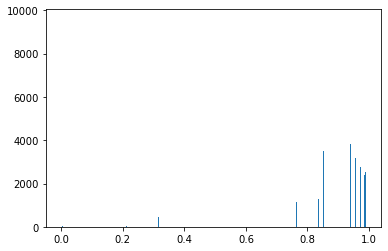

In [47]:
plt.hist(times, bins=time_bins);

In [48]:
hist, bin_edges = np.histogram(times, time_bins)

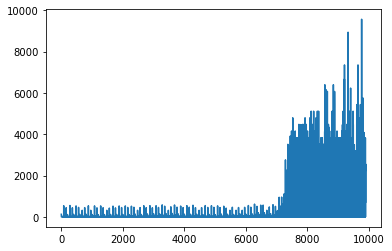

In [49]:
plt.plot(hist)

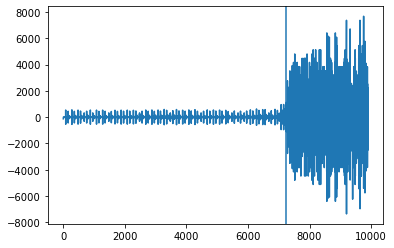

In [52]:
plt.plot(np.diff(hist))
plt.axvline(7242)

In [51]:
for i, diff in enumerate(np.diff(hist)):
    if diff > 1000:
        idx = i
        break
print(idx)
dvs_start_moving = bin_edges[idx]
print(f"start moving time: {bin_edges[idx]}")

7242
start moving time: 0.7243171183673187


In [37]:
np.argmax(np.diff(hist) > 1000)

714

In [38]:
poses = []
for i in range(1, c3d_helper.reader.frame_count):
    T = c3d_helper.marker_T_at_frame_vector(i)
    poses.append(T)


In [39]:
poses = np.array(poses)

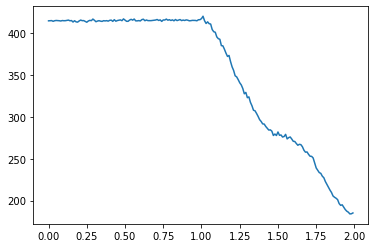

In [40]:
plt.plot(c3d_helper.frame_times[:200], poses[:200, 0, 3])

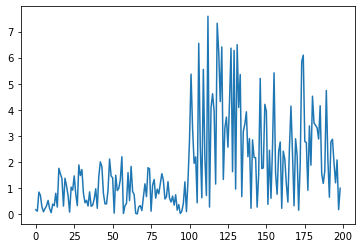

In [41]:
plt.plot(np.abs(np.diff(poses[:200, 0, 3], 1)))

In [42]:
for i, diff in enumerate(np.abs(np.diff(poses[:200, 0, 3]))):
    if diff > 3:
        idx = i
        break
print(idx)
vicon_start_moving = c3d_helper.frame_times[idx]
print(f"start moving time: {c3d_helper.frame_times[idx]}")

101
start moving time: 1.010625774473358


In [43]:
np.argmax(np.abs(np.diff(poses[:, 0, 3])) > 3)

101

In [44]:
vicon_start_moving - dvs_start_moving

0.29571523783085873

In [25]:
%%timeit
c3d_helper.find_start_moving_time()

1.07 s ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
